# SIS on infinite random $k$-regular graph

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [98]:
T = 70         # final time
k = 4          # degree
γ = 4e-1       # prob. of zero patient
ΔT = 0.2   # discretization
λ = 0.1    # prob. of transmission
ρ = 0.2   # prob. of recovery

0.2

In [103]:
svd_trunc = TruncBond(4)
maxiter = 200
tol = 1e-5
pᵢ⁰ = [1-γ, γ]
A, iters, Δs = sis_infinite_graph(floor(Int, T/ΔT), k, pᵢ⁰, λ*ΔT, ρ*ΔT; svd_trunc, maxiter, tol);

Iterating BP on infinite graph  10%|██▏                  |  ETA: 0:00:36
  iter:  20/200
  Δ:     1.3416247e-5/1.0e-5

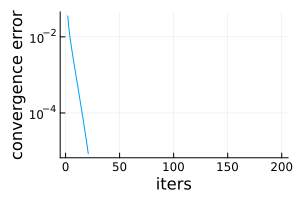

In [104]:
plot(Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="")

In [105]:
# compute magnetization, correlation and covariance
wᵢ = fill(SISFactor(λ, ρ), floor(Int, T/ΔT))
b, m, c = observables_infinite_graph(A, k, pᵢ⁰, wᵢ; svd_trunc, showprogress=true);

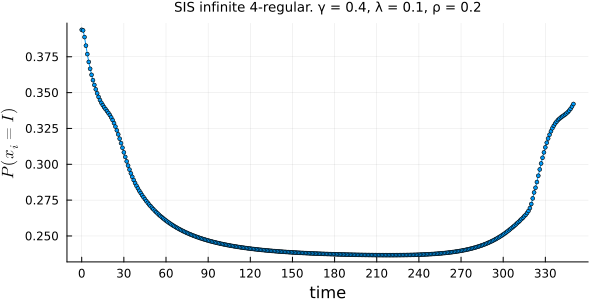

In [107]:
marg = [bᵗ[INFECTED] for bᵗ in b]
pl_marg = plot(0:floor(Int, T/ΔT), marg, m=:o, xlabel="time", ylabel="\$P(x_i=I)\$", label="",
    size=(600,300), xticks=0:30:floor(Int, T/ΔT), ms=2,titlefontsize=9,
    title = "SIS infinite $k-regular. γ = $γ, λ = $λ, ρ = $ρ")

In [114]:
A[60][:,:,1,1]

4×4 Matrix{Float64}:
 -1.0           0.00263135    0.000147916  -1.59429e-5
  0.00542907   -0.000691156   0.000329257   0.00200893
  0.000140721   0.0427152    -0.0217506    -0.133804
 -1.8229e-5     0.29187      -0.147308     -0.922614

In [115]:
A[61][:,:,1,1]

4×4 Matrix{Float64}:
 -1.0           0.00261266    0.000148282  -1.49108e-5
  0.00540108   -0.000691745   0.000315341   0.00201474
  0.000140711   0.0403032    -0.01965      -0.126499
 -2.21848e-5    0.291838     -0.140837     -0.924831

In [118]:
using ColorSchemes
function plot_autocovs!(pl, c; skip_even=true, us = 10:50:size(c,1)-1,
        cg = cgrad(:matter, length(us), categorical=true), kw...)
    step = skip_even ? 2 : 1
    ylabel = "\$\\langle x_i^t x_i^{t+\\Delta t}\\rangle-" * 
        "\\langle x_i^t\\rangle\\langle x_i^{t+\\Delta t}\\rangle \$"
    xlabel = "\$\\Delta t \$"
    plot!(pl ;xlabel, ylabel, legend=:outertopright, 
        title="SIS infinite $k-regular. γ = $γ, λ = $λ, ρ = $ρ. Matrix size $(svd_trunc.mprime)")
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-step:1, c[(0:step:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j]; kw...) 
    end
    pl
end  
plot_autocovs(args...; kwargs...) = plot_autocovs!(plot(), args...; kwargs...)

plot_autocovs (generic function with 1 method)

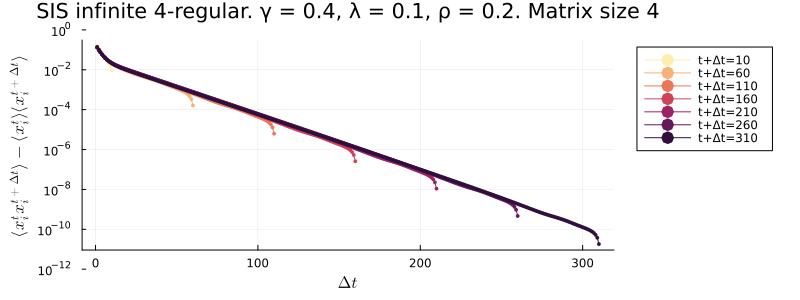

In [119]:
skip_even = false
cc = map(x -> x > 0 ? x : 1e-17, c);
pl_autocov = plot_autocovs(cc; skip_even, yaxis=:log10, yticks=7, 
    size=(800,300), margin=5Plots.mm, ms=2)

## Varying the size of matrices

In [21]:
sizes = [4, 10, 20]
magnetizations = [zeros(0) for _ in sizes]
covariances = [zeros(0, 0) for _ in sizes];

In [22]:
for s in eachindex(sizes)
    println("### Size $s of $(length(sizes))")
    cg = cgrad(:matter, length(sizes), categorical=true)
    sz = sizes[s]
    svd_trunc = TruncBond(sz)
    A, iters, Δs = sis_infinite_graph(T, k, pᵢ⁰, λ, ρ; svd_trunc, maxiter, tol)
    iters == maxiter && error("BP did not converge for matrix size $sz")
    wᵢ = fill(SISFactor(λ, ρ), T)
    b, magnetizations[s], covariances[s] = observables_infinite_graph(A, k, pᵢ⁰, wᵢ; svd_trunc, showprogress=true)
end

Iterating BP on infinite graph   9%|█▉                   |  ETA: 0:08:24
  iter:  18/200
  Δ:     0.0010565/0.001

In [25]:
pl_mag = plot(); pl_cov = plot()
cg = cgrad(:matter, length(sizes), categorical=true)

for s in eachindex(sizes)
    sz = sizes[s]
    plot!(pl_mag, 0:T, magnetizations[s], m=:o, xlabel="time", ylabel="\$P(x_i=I)\$",
        size=(600,300), xticks=0:10:T, ms=2, c = cg[s], msc=cg[s],
        label = "Matrix size $sz", legend=:topleft)
    us = 10:20:T
    plot_autocovs!(pl_cov, covariances[s]; us, cg = cgrad(fill(cg[s], length(us))), yaxis=:log10,
        yticks = 4)
    plot!(pl_cov, title="")
end

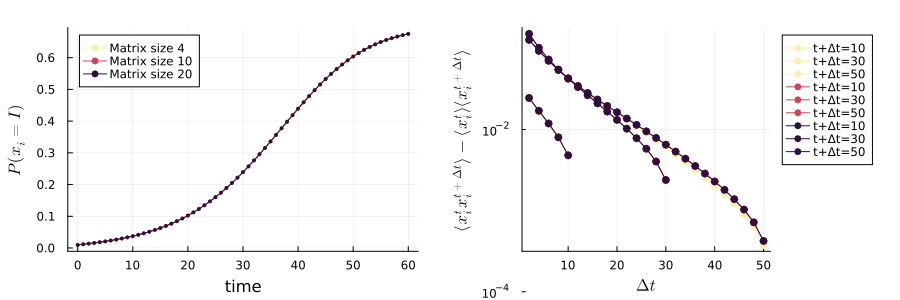

In [26]:
plot(pl_mag, pl_cov, size=(900,300), margin=5Plots.mm)